In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import h5py
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
import os
import numpy as np
from wordcloud import WordCloud

In [2]:
# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])
real_logos = images

# Normalize pixel values to the range [0, 1]
real_logos = real_logos.astype('float32') / 255.0
# Split the data into training and validation sets
train_data, val_data = train_test_split(real_logos, test_size=0.2, random_state=42)

train_data_tenth = train_data[:int(len(train_data)/10)]


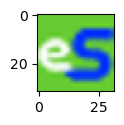

In [3]:
# Investigate the icon data using matplotlib
fig = plt.figure(figsize=(1, 1))
plt.imshow(np.transpose(images[20], (1, 2, 0)))

In [4]:
# Initiate a GAN model using tensorflow & keras
# Generator
latent_dim = 100
generator = keras.Sequential()
generator.add(layers.Dense(256, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(512, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(1024, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(32*32*3, activation="relu", input_dim=latent_dim))
generator.add(layers.Reshape((32, 32, 3)))

# Discriminator
discriminator = keras.Sequential()
discriminator.add(layers.Flatten(input_shape=(32, 32, 3)))
discriminator.add(layers.Dense(1024, activation='relu'))
discriminator.add(layers.Dense(512, activation='relu'))
discriminator.add(layers.Dense(256, activation='relu'))
discriminator.add(layers.Dense(1, activation='sigmoid'))

# Discriminator Network
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Create the GAN model
discriminator.trainable = False
gan = keras.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [5]:
def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

# Create a function to generate a batch of fake images
def generate_fake_samples(generator, n_samples, noise_dim):
    noise = generate_noise(n_samples, noise_dim)
    fake_logos = generator.predict(noise)
    return fake_logos

# Train the GAN model
def train_gan(generator, discriminator, gan, train_data, n_epochs, n_batches, batch_size, latent_dim):
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            start_index = batch * batch_size
            end_index = min((batch + 1) * batch_size, train_data.shape[0])
            batch_indices = np.arange(start_index, end_index)
            real_batch = train_data[batch_indices]
            real_batch = np.transpose(real_batch, (0, 2, 3, 1))

            noise = generate_noise(real_batch.shape[0], latent_dim)
            fake_batch = generator.predict(noise)

            X = np.concatenate([real_batch, fake_batch])
            y = np.concatenate([np.ones((real_batch.shape[0], 1)), np.zeros((real_batch.shape[0], 1))])
            discriminator_loss = discriminator.train_on_batch(X, y)

            # Train the Generator
            noise = generate_noise(real_batch.shape[0], latent_dim)
            y = np.ones((real_batch.shape[0], 1))
            generator_loss = gan.train_on_batch(noise, y)

        #Print the loss at the end of each epoch
        print(f'Epoch {epoch + 1}/{n_epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}')
            

In [7]:
n_epochs = 10
batch_size = 2048
n_batches = int(np.ceil(train_data.shape[0] / batch_size))

train_gan(generator, discriminator, gan, train_data, n_epochs, n_batches, batch_size, latent_dim)

64/64 [==============================] - 0s 5ms/step
Epoch 1/10 - Discriminator Loss: 0.0013505418319255114 - Generator Loss: 9.438539505004883
64/64 [==============================] - 0s 4ms/step
Epoch 2/10 - Discriminator Loss: 0.0003319184761494398 - Generator Loss: 11.107815742492676
64/64 [==============================] - 0s 4ms/step
Epoch 3/10 - Discriminator Loss: 0.00024200296320486814 - Generator Loss: 8.508413314819336
64/64 [==============================] - 0s 3ms/step
Epoch 4/10 - Discriminator Loss: 0.0005752399447374046 - Generator Loss: 11.924009323120117
64/64 [==============================] - 0s 3ms/step
Epoch 5/10 - Discriminator Loss: 0.002369132824242115 - Generator Loss: 14.237690925598145
64/64 [==============================] - 0s 4ms/step
Epoch 6/10 - Discriminator Loss: 0.007546084467321634 - Generator Loss: 12.608261108398438
64/64 [==============================] - 0s 3ms/step
Epoch 7/10 - Discriminator Loss: 0.012940389104187489 - Generator Loss: 17.53822

1563/1563 [==============================] - 12s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

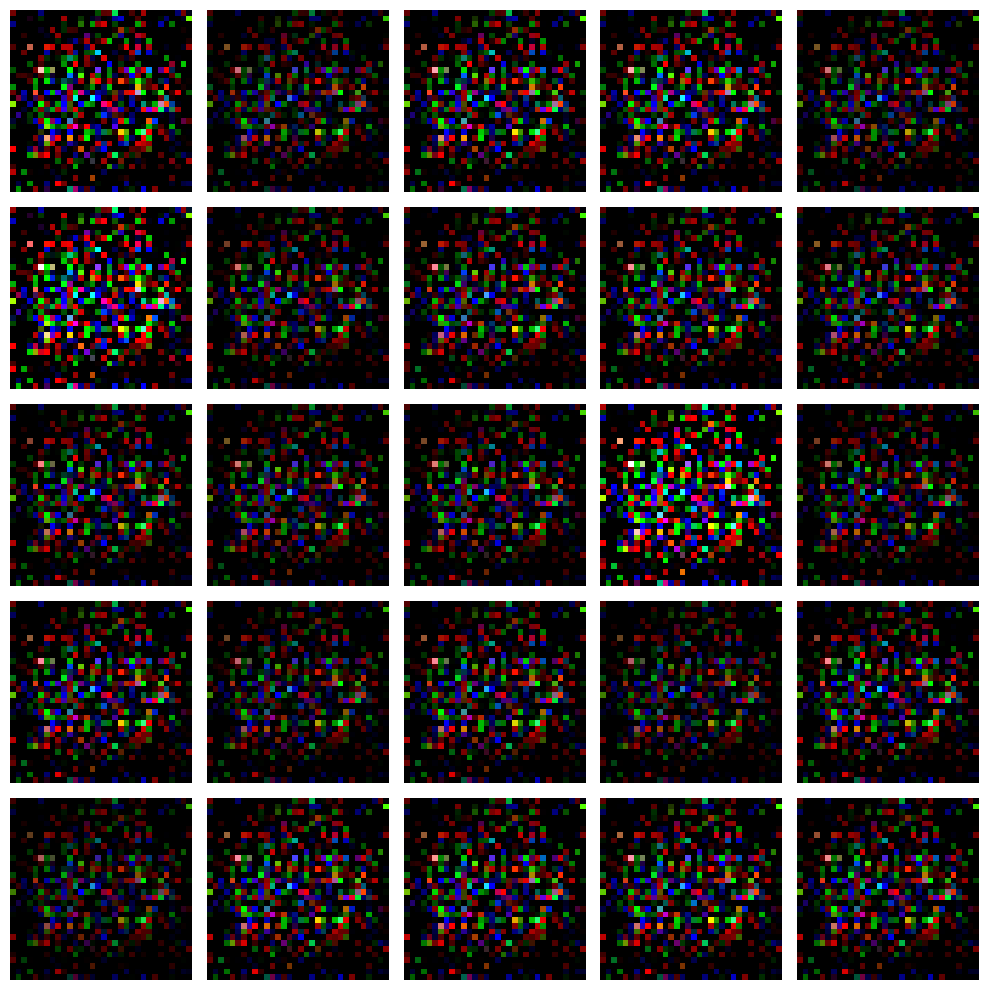

In [12]:
import matplotlib.pyplot as plt

# Generate random noise
num_images_to_generate = 50000
latent_dim = 100
noise = generate_noise(num_images_to_generate, latent_dim)

# Generate fake images
fake_images = generator.predict(noise)

# Filter images based on discriminator predictions
predictions = discriminator.predict(fake_images)
predictions = predictions.squeeze()  # Remove singleton dimensions
threshold = 0.001  # Adjust the threshold as needed
filtered_images = fake_images[predictions > threshold]

# Visualize the filtered images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filtered_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

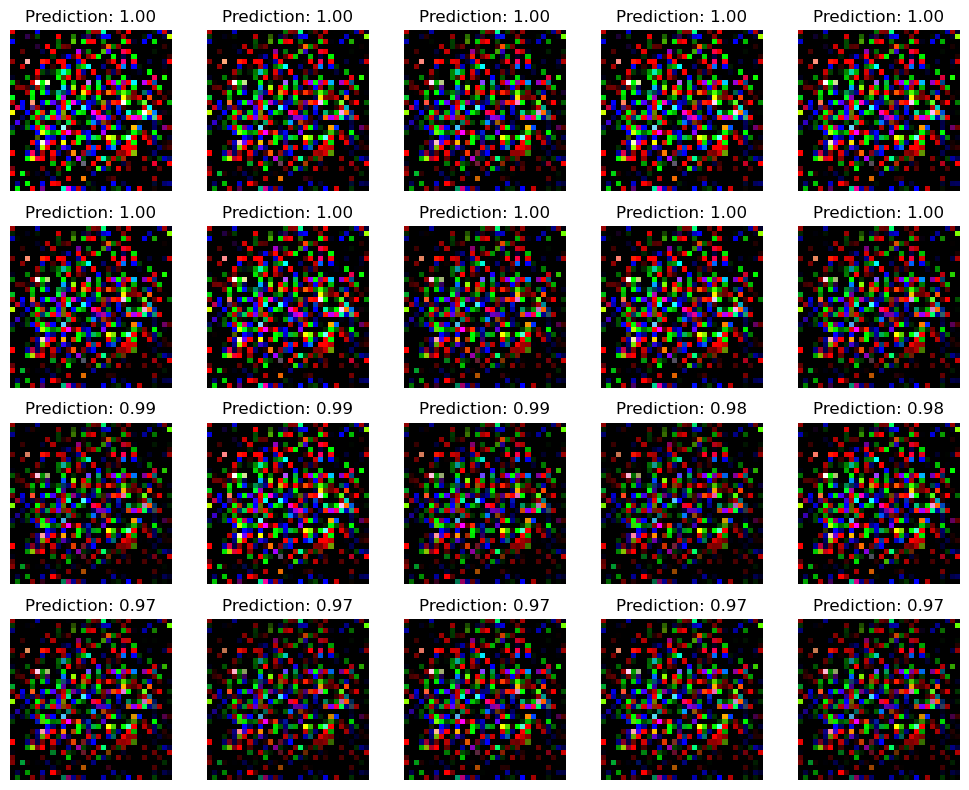

In [20]:
# Sort predictions in descending order and get the indices of top 20
top_indices = predictions.argsort()[-20:][::-1]

# Select the top 20 images
filtered_images = fake_images[top_indices]
filtered_predictions = predictions[top_indices]

# Visualize the filtered images and their predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filtered_images[i])
    ax.set_title(f"Prediction: {filtered_predictions[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


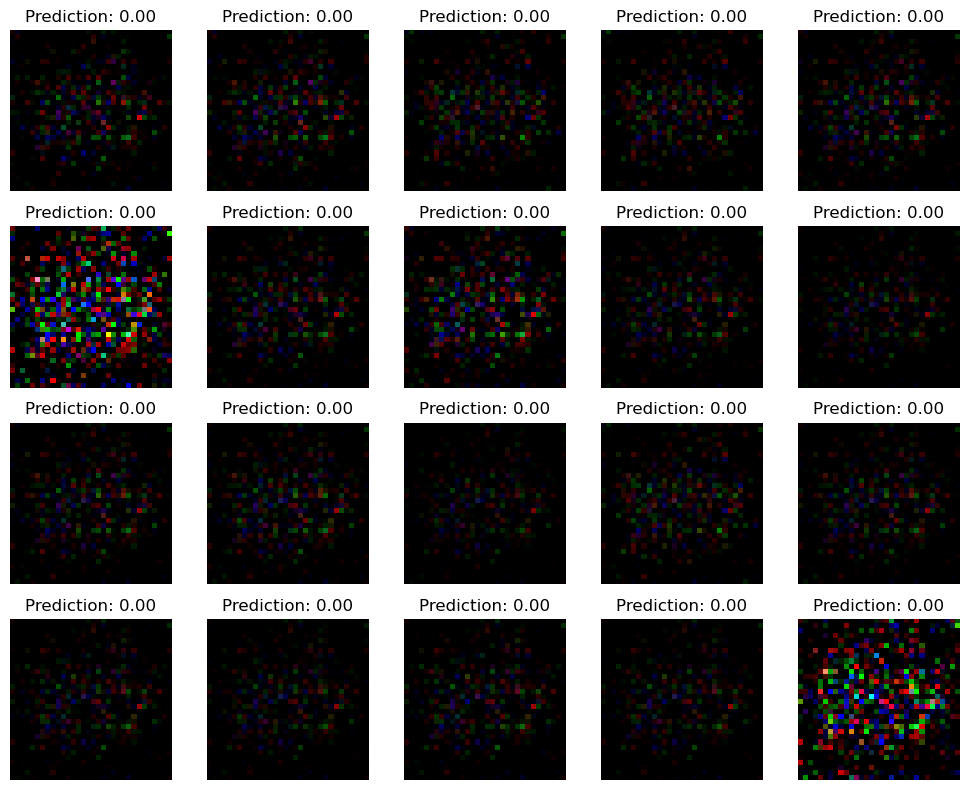

In [21]:
# Sort predictions in ascending order and get the indices of bottom 20
bottom_indices = predictions.argsort()[:20]

# Select the bottom 20 images and predictions
filtered_bottom_images = fake_images[bottom_indices]
filtered_bottom_predictions = predictions[bottom_indices]

# Visualize the filtered bottom images and their predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(filtered_bottom_images[i])
    ax.set_title(f"Prediction: {filtered_bottom_predictions[i]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()